In [113]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import math
import os

from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
%matplotlib inline

In [114]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
train_path = '../input/brain-t/Lec/Train'
valid_path = '../input/brain-t/Lec/Val'

train_gen = ImageDataGenerator(
    #shear_range=0.2,
    
    #zoom_range=0.2,
    #rotation_range=20,
  #  width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
   # channel_shift_range=10.,
   # fill_mode="nearest",
rescale=1./255,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False
)

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True, rescale=1./255.)

train_batches =train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['Glioma', 'Meningioma', 'Pituitary tumor'],
                                              batch_size=10
                                             )

valid_batches = ImageDataGenerator( rescale=1./255,
                                    
                                    ).flow_from_directory(directory=valid_path, target_size=(224,224), 
    classes=['Glioma', 'Meningioma', 'Pituitary tumor'], batch_size=10,shuffle=False)

Found 2456 images belonging to 3 classes.
Found 616 images belonging to 3 classes.


In [115]:
IMAGE_SIZE = [224, 224]

In [ ]:
model5 = Sequential()

# Convolutional layer 1
model5.add(Conv2D(64,(3,3), input_shape=(224, 224, 3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model5.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model5.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model5.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
# Convolutional layer 3
model5.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model5.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))


model5.add(Flatten())

# Full connect layers

model5.add(Dense(units= 1024, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=512, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=3, activation='softmax'))
model5.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])


In [116]:

model1 = tf.keras.applications.DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [118]:
# don't train existing weights
for layer in model1.layers:
    layer.trainable = False

In [119]:
x = model1.output
x = layers.Flatten()(x)


#x = layers.Dense(1024, activation='relu')(x)


x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(3, activation='softmax')(x)


model = keras.Model(inputs=model1.inputs, outputs=outputs)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [120]:

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [76]:
 callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [92]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [121]:
history = model.fit_generator(generator=train_batches,
                                    #steps_per_epoch=len(train_batches),
                                 validation_data=valid_batches, 
                                 #validation_steps=len(valid_batches), 
                                    epochs=50,   callbacks=[model5_es, model5_rlr, model5_mcp]
                             )

Epoch 1/50
246/246 [==============================] - 27s 87ms/step - loss: 1.8059 - accuracy: 0.7740 - val_loss: 0.2505 - val_accuracy: 0.8669
Epoch 2/50
246/246 [==============================] - 19s 77ms/step - loss: 0.2569 - accuracy: 0.8522 - val_loss: 0.2760 - val_accuracy: 0.8474
Epoch 3/50
246/246 [==============================] - 20s 80ms/step - loss: 0.2670 - accuracy: 0.8445 - val_loss: 0.2099 - val_accuracy: 0.8831
Epoch 4/50
246/246 [==============================] - 20s 80ms/step - loss: 0.2178 - accuracy: 0.8742 - val_loss: 0.1694 - val_accuracy: 0.8912
Epoch 5/50
246/246 [==============================] - 19s 77ms/step - loss: 0.2222 - accuracy: 0.8689 - val_loss: 0.1832 - val_accuracy: 0.8831
Epoch 6/50
246/246 [==============================] - 21s 86ms/step - loss: 0.1891 - accuracy: 0.8872 - val_loss: 0.1492 - val_accuracy: 0.9042
Epoch 7/50
246/246 [==============================] - 21s 84ms/step - loss: 0.1728 - accuracy: 0.8909 - val_loss: 0.1645 - val_accuracy:

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f0f17151f80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


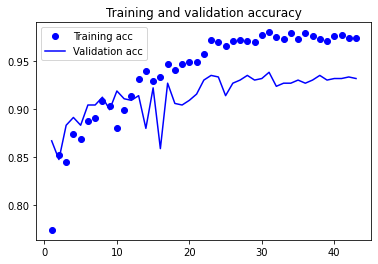

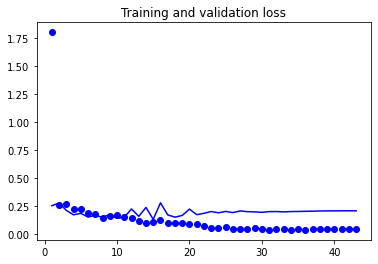

In [122]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.savefig('accuracy.png')
plt.show()

In [123]:
from tensorflow.keras.models import load_model

model.save('model_(3).h5')

In [124]:
test_model = load_model('./model_(3).h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


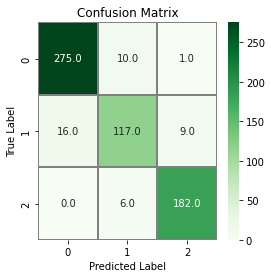

<Figure size 432x288 with 0 Axes>

In [125]:
predictions_1 = test_model.predict_generator(generator=valid_batches, steps=len(valid_batches), verbose=0)

pred_label = np.argmax(predictions_1,axis=1)
classes = np.argmax(predictions_1, axis=1)
cm = confusion_matrix(valid_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

In [126]:
predictions = test_model.predict_generator(valid_batches, steps=1, verbose=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [127]:
rounded_prediction = np.argmax(predictions, axis=-1)
for i in rounded_prediction:
    print(i)

0
0
0
0
0
0
0
0
0
0


In [128]:
cm = confusion_matrix(y_true=valid_batches.labels, y_pred=pred_label)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(classification_report(y_true=valid_batches.labels, y_pred=pred_label))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       286
           1       0.88      0.82      0.85       142
           2       0.95      0.97      0.96       188

    accuracy                           0.93       616
   macro avg       0.92      0.92      0.92       616
weighted avg       0.93      0.93      0.93       616



Confusion matrix, without normalization
[[275  10   1]
 [ 16 117   9]
 [  0   6 182]]


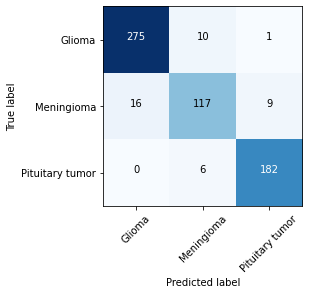

In [129]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [131]:
from keras.utils.np_utils import to_categorical


In [132]:
y_score = model.predict_generator(valid_batches)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [134]:
classes = dict((v, k) for k, v in valid_batches.class_indices.items())
num_classes = len(classes)
num_samples = len(valid_batches)

In [135]:
y_true_categorical = valid_batches.classes
y_true = (to_categorical(y_true_categorical, num_classes = num_classes))

In [136]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


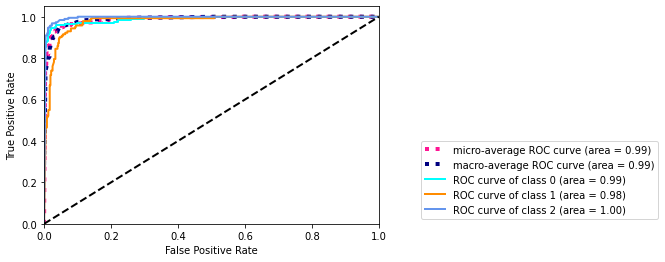

In [137]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.title('Receiver operating characteristic (ROC) to Multi-Class Validation Set (' + model_name + ')')
plt.legend(bbox_to_anchor=(1.85,0), loc="lower right")
#plt.savefig(model_path + '0_results/Model' + '_' + model_name + '_' + str(epochs) + '_epochs_ROC_Validation.png', dpi=600, bbox_inches="tight")
plt.show()

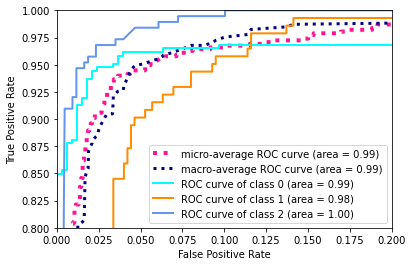

In [138]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
